In [2]:
# Prelude
import ralphlib
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

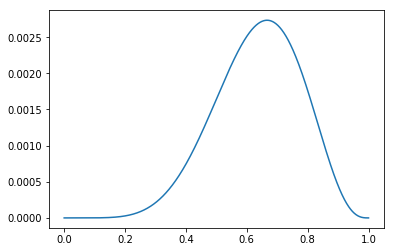

In [23]:
# 3E1
def world_toss_likelihood(num_water, num_tries):
    return lambda grid: stats.binom.pmf(num_water, num_tries, grid)

grid = np.linspace(start=0, stop=1, num=1000)
posterior = pd.Series(
    data=ralphlib.grid_approx(
        ralphlib.uniform_prior,
        world_toss_likelihood(6, 9),
        grid
    ),
    index=grid
)
posterior.plot()

In [24]:
posterior[posterior.index >= 0.2].sum()

0.9991439048705782

(array([   38.,   422.,  2299.,  6811., 13779., 21123., 24630., 19985.,
         9480.,  1433.]),
 array([0.08308308, 0.17347347, 0.26386386, 0.35425425, 0.44464464,
        0.53503504, 0.62542543, 0.71581582, 0.80620621, 0.8965966 ,
        0.98698699]),
 <a list of 10 Patch objects>)

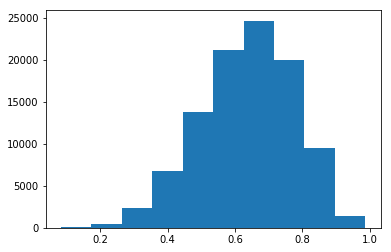

In [25]:
sample_size = 100000
sample = ralphlib.sample(posterior, sample_size)
plt.hist(sample)

In [26]:
param_values, counts = np.unique(sample, return_counts=True)
sample_freq = pd.Series(
    index=param_values,
    data=counts / sample_size
)

In [27]:
# 3E1
# Note: we are working with frequencies here! 
sample_freq[sample_freq.index < 0.2].sum()

0.0008300000000000002

In [28]:
# 3E2
sample_freq[sample_freq.index > 0.8].sum()

0.11969

In [29]:
# 3E3
sample_freq[(sample_freq.index > 0.2) & (sample_freq.index < 0.8)].sum()

0.8794799999999999

In [30]:
# 2E4
# Note: we are working directly with samples here!
# It's not easy (or possible? I think you need actual occurrence numbers and 
# not just frequency/probability?) to compute quantiles over frequencies/
# probabilities.
quantile0_2 = np.quantile(sample, 0.2)
quantile0_2

0.5175175175175175

In [31]:
sample_freq[sample_freq.index <= quantile0_2].sum()

0.20065999999999998

In [32]:
# 2E5
quantile0_8 = np.quantile(sample, 0.8)
quantile0_8

0.7607607607607607

In [33]:
sample_freq[sample_freq.index > quantile0_8].sum()

0.19836

In [40]:
# 3E6
def hdpi(sample, density):
    """Compute the highest density interval of the given density
    using the given samples from a distribution."""
    param_values, counts = np.unique(sample, return_counts=True)
    distribution = pd.Series(
        index=param_values,
        data=counts / len(sample)
    )
    
    distr_cumsum = distribution.cumsum()
    cumsum_density = distr_cumsum + density
    cumsum_density = cumsum_density[cumsum_density <= 1.0]
    # TODO do we need to finagle the np.quantile call to ensure it
    # only returns parameter values in the grid?
    q_series = cumsum_density.apply(lambda q: np.quantile(sample, q))
    
    fin_series = pd.Series(
        data=(q_series.values - q_series.index),
        index=q_series
    )
    
    fin_df = pd.DataFrame(
        data={
            "rhs": q_series.values,
            "width": q_series.values - q_series.index
        },
        index=q_series.index
    )
    
    # interval of given density with minimum width
    lhs = fin_df["width"].idxmin()
    return (lhs, fin_df["rhs"][lhs])

In [35]:
hdpi(sample, 0.66)

(0.5195195195195195, 0.7907907907907907)

In [36]:
# 3E7
outside_half_density = (1-0.66)/2
eq_lhs = np.quantile(sample, outside_half_density)
eq_rhs = np.quantile(sample, 1 - outside_half_density)
symmetric_interval = (eq_lhs, eq_rhs)

In [37]:
# bonus: what is the value of p with maximal density?
sample_freq.idxmax()

0.7007007007007007

In [41]:
# bonus: widths of the two intervals
symmetric_width = symmetric_interval[1] - symmetric_interval[0]
hpdi_width = hpdi_interval[1] - hpdi_interval[0]
(symmetric_width, hpdi_width)

(0.27427427427427425, 0.19419419419419415)

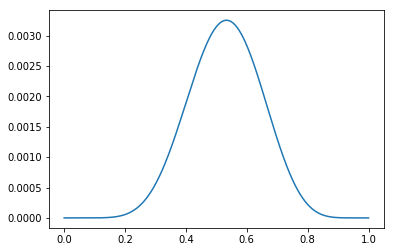

In [43]:
# 3M1
posterior2 = pd.Series(
    data=ralphlib.grid_approx(
        ralphlib.uniform_prior,
        world_toss_likelihood(8, 15),
        grid
    ),
    index=grid
)
posterior2.plot()

In [46]:
# 3M2
sample2 = ralphlib.sample(posterior2, 10000)
hdpi(sample2, 0.9)

(0.3353353353353353, 0.7227227227227228)

(array([   7.,   35.,  105.,  276.,  534.,  776., 1152., 1429., 1530.,
        1374., 1111.,  798.,  522.,  253.,   98.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 15 Patch objects>)

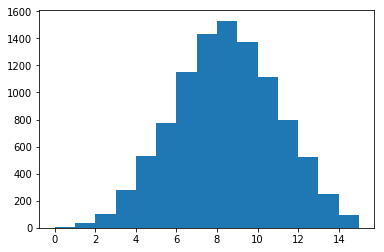

In [56]:
# 3M3
posterior_predictive_samples = np.vectorize(lambda p: np.random.binomial(15, p))(sample2)
plt.hist(posterior_predictive_samples, range(0, 16))

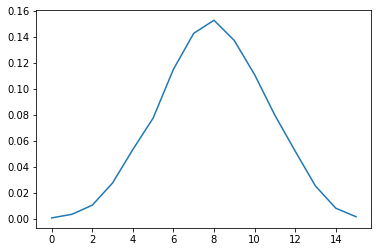

In [63]:
pp_vals, pp_counts = np.unique(posterior_predictive_samples, return_counts=True)
pp_distr = pd.Series(
    data=pp_counts / len(posterior_predictive_samples),
    index=pp_vals
)
pp_distr.plot()

In [65]:
pp_distr[8]

0.153